In [ ]:
# first stage model [train]

In [ ]:
from google.colab import drive, files
import os

drive.mount('/content/drive')  # drive をマウント
COLAB = "/content/drive/MyDrive/studentcup-2021-spring"  # colaboratory の path (必要時応じて変更)
os.chdir(COLAB)
!pip install --quiet category_encoders
!pip install --quiet xfeat

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import requests
import os

# make config
OUTPUT = os.path.join(COLAB, 'output')
INPUT = os.path.join(COLAB, 'input')
SUBMISSION = os.path.join(COLAB, 'submission')
EXP_NAME = "run1"
EXP = os.path.join(OUTPUT, EXP_NAME)
PREDS = os.path.join(EXP, "preds")
TRAINED = os.path.join(EXP, "trained")
FEATURE = os.path.join(EXP, "feature")
REPORTS = os.path.join(EXP, "reports")

# make experiments environment
dirs = [
        OUTPUT,
        SUBMISSION,
        FEATURE,
        EXP,
        PREDS,
        TRAINED,
        REPORTS
        ]

for v in dirs:
    if not os.path.isdir(v):
        print(f"making {v}")
        os.makedirs(v)

making /content/drive/MyDrive/studentcup-2021-spring/output/run1/reports


In [ ]:
import datetime
import logging
import random

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import joblib
from matplotlib_venn import venn2
from sklearn import model_selection
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

import itertools

from lightgbm import LGBMModel
import category_encoders as ce
import xfeat

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import layers as L
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
# seed 固定
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(46)

In [ ]:
# model save and load 用のクラス
class Util:
    @classmethod
    def dump(cls, value, path):
        os.makedirs(os.path.dirname(path), exist_ok=True)
        joblib.dump(value, path, compress=True)

    @classmethod
    def load(cls, path):
        return joblib.load(path)

# log 用のクラス
class Logger:
    def __init__(self, path):
        self.general_logger = logging.getLogger(path)
        stream_handler = logging.StreamHandler()
        file_general_handler = logging.FileHandler(os.path.join(path, 'Experiment.log'))
        if len(self.general_logger.handlers) == 0:
            self.general_logger.addHandler(stream_handler)
            self.general_logger.addHandler(file_general_handler)
            self.general_logger.setLevel(logging.INFO)

    def info(self, message):
        # display time
        self.general_logger.info('[{}] - {}'.format(self.now_string(), message))

    @staticmethod
    def now_string():
        return str(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

# logger の設定
logger = Logger(REPORTS)


## laod data

In [ ]:
train = pd.read_csv(INPUT+"/train.csv")
test = pd.read_csv(INPUT+"/test.csv")
sample_sub = pd.read_csv(INPUT+"/sample_submit.csv")
genre_labels = pd.read_csv(INPUT+"/genre_labels.csv")

## feature engineering - load features -

In [ ]:
class GroupingEngine: 

    def __init__(self, group_key, group_values, agg_methods):
        self.group_key = group_key
        self.group_values = group_values  # debug

        ex_trans_methods = ["val-mean", "z-score"]
        self.ex_trans_methods = [m for m in agg_methods if m in ex_trans_methods]
        self.agg_methods = [m for m in agg_methods if m not in self.ex_trans_methods]
        self.df = None

    def fit(self, input_df, y=None):
        if not self.agg_methods:
            return
            
        new_df = []
        for agg_method in self.agg_methods:

            for col in self.group_values:
                if callable(agg_method):
                    agg_method_name = agg_method.__name__
                else:
                    agg_method_name = agg_method

                new_col = f"agg_{agg_method_name}_{col}_grpby_{self.group_key}"
                df_agg = (input_df[[col] + [self.group_key]].groupby(self.group_key)[[col]].agg(agg_method))
                df_agg.columns = [new_col]
                new_df.append(df_agg)
        self.df = pd.concat(new_df, axis=1).reset_index()

    def transform(self, input_df):
        if self.agg_methods:
            output_df = pd.merge(input_df[[self.group_key]], self.df, on=self.group_key, how="left")
        else:
            output_df = input_df[[self.group_key]].copy()

        if len(self.ex_trans_methods) != 0:
            output_df = self.ex_transform(input_df, output_df)
        output_df.drop(self.group_key, axis=1, inplace=True)
        return output_df

    def ex_transform(self, df1, df2):
        """
        df1: input_df
        df2: output_df
        return: output_df (added ex transformed features)
        """

        if "val-mean" in self.ex_trans_methods:
            _agg_df = xfeat.aggregation(df1, 
                                        group_key=self.group_key,
                                        group_values=self.group_values, 
                                        agg_methods=["mean"])[0]
            df2[self._get_col("val-mean")] = df1[self.group_values].values - _agg_df[self._get_col("mean")].values

        if "z-score" in self.ex_trans_methods:
            _agg_df = xfeat.aggregation(df1, 
                                        group_key=self.group_key,
                                        group_values=self.group_values, 
                                        agg_methods=["mean", "std"])[0]
            df2[self._get_col("z-score")] = ((df1[self.group_values].values - _agg_df[self._get_col("mean")].values) 
                                                / (_agg_df[self._get_col("std")].values + 1e-8))

        return df2

    def _get_col(self, method):
        return [f"agg_{method}_{group_val}_grpby_{self.group_key}" for group_val in self.group_values]

    def fit_transform(self, input_df, y=None):
        self.fit(input_df, y=y)
        return self.transform(input_df)



class TargetEncodingEngine:
    """
    refer to https://github.com/nyk510/atmacup10
    """

    def __init__(self, use_columns, cv):

        self.mapping_df_ = None
        self.y_mean_ = None
        self.use_columns = use_columns
        self.cv = list(cv)
        self.n_fold = len(self.cv)

    def create_mapping(self, input_df, y):
        self.mapping_df_ = {}
        self.y_mean_ = np.mean(y)

        out_df = pd.DataFrame()
        target = pd.Series(y)

        for col_name in self.use_columns:
            keys = input_df[col_name].unique()
            x = input_df[col_name]

            oof = np.zeros_like(x, dtype=np.float)

            for idx_train, idx_valid in self.cv:
                _df = target[idx_train].groupby(x[idx_train]).mean()
                _df = _df.reindex(keys)
                _df = _df.fillna(_df.mean())
                oof[idx_valid] = input_df[col_name][idx_valid].map(_df.to_dict())

            out_df[col_name] = oof

            self.mapping_df_[col_name] = target.groupby(x).mean()

        return out_df

    def fit(self, input_df: pd.DataFrame, y=None, **kwargs) -> None:
        _ = self.create_mapping(input_df, y=y)

    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        out_df = pd.DataFrame()

        for c in self.use_columns:
            out_df[c] = input_df[c].map(self.mapping_df_[c]).fillna(self.y_mean_)

        return out_df.add_prefix('TE_') 

    
    def fit_transform(self, input_df, y=None):
        self.fit(input_df, y=y)
        return self.transform(input_df)   

In [ ]:
# 実際に前処理をする関数を定義
def get_numerical_features(input_df):
    # そのままの数値特徴
    cols = ['popularity',
            'duration_ms',
            'acousticness',
            'positiveness',
            'danceability',
            'loudness',
            'energy',
            'liveness',
            'speechiness',
            'instrumentalness']
    output_df = input_df[cols].copy()
    return output_df.add_prefix("lgb__")


def get_ce_features(input_df):
    # count encording した特徴量
    tmp = input_df["popularity"].astype(str).str.zfill(2)
    tmp = pd.Series([i[0] for i in tmp])
    _input_df = input_df.copy()
    _input_df["pop10region"] = tmp + input_df["region"]

    cols = ["region", "pop10region"]
    encoder = ce.CountEncoder()
    output_df = encoder.fit_transform(_input_df[cols]).add_prefix("CE_")
    return output_df.add_prefix("lgb__")


def get_oe_features(input_df):
    # ordinal encording (label encording)した特徴量
    tmp = input_df["popularity"].astype(str).str.zfill(2)
    tmp = pd.Series([i[0] for i in tmp])
    _input_df = input_df.copy()
    _input_df["pop10region"] = tmp + input_df["region"]
    cols = ["region", "pop10region"]
    encoder = ce.OrdinalEncoder()
    output_df = encoder.fit_transform(_input_df[cols]).add_prefix("OE_")
    return output_df.add_prefix("lgb__")


def get_tmpo_features(input_df):
    # tmpo に関する特徴量
    _df = input_df["tempo"].str.split("-").apply(pd.Series).astype(float)
    _df.columns = ["tempo_low", "tempo_high"]
    output_df = _df.copy()
    output_df["diff_tempo"] = _df["tempo_high"] - _df["tempo_low"]
    return output_df.add_prefix("lgb__")


def get_binned_popularity_features(input_df):
    # popularity の10の位と1の位の特徴量
    tmp = input_df["popularity"].astype(str).str.zfill(2)
    tmp = [[i[0], i[1]] for i in tmp]
    output_df = pd.DataFrame(tmp, columns=["popularity10", "popularity01"])
    return output_df.astype(int).add_prefix("lgb__")

# 集約特徴量作成時に使用
def max_min(x):
    return x.max() - x.min()

def q75_q25(x):
    return x.quantile(0.75) - x.quantile(0.25)


def get_agg_region_features(input_df):
    # region をキーにした集約特徴量
    _input_df = pd.concat([get_tmpo_features(input_df),
                           input_df], axis=1)
    group_key = "region"
    group_values = ['popularity',
                    'duration_ms',
                    'acousticness',
                    'positiveness',
                    'danceability',
                    'loudness',
                    'energy',
                    'liveness',
                    'speechiness',
                    'instrumentalness', 
                    ]
    agg_methods = ["min", "mean", "max", max_min, "z-score", "var", "skew", pd.DataFrame.kurt]
    encoder = GroupingEngine(group_key=group_key, group_values=group_values, agg_methods=agg_methods)
    output_df = encoder.fit_transform(_input_df)
    return output_df.add_prefix("lgb__")


def get_agg_pop10region_features(input_df):
    tmp = input_df["popularity"].astype(str).str.zfill(2)
    tmp = pd.Series([i[0] for i in tmp])
    _input_df = pd.concat([input_df, 
                           get_tmpo_features(input_df)], axis=1)
    _input_df["pop10region"] = tmp + input_df["region"]
    group_key = "pop10region"
    group_values = ['popularity',
                    'duration_ms',
                    'acousticness',
                    'positiveness',
                    'danceability',
                    'loudness',
                    'energy',
                    'liveness',
                    'speechiness',
                    'instrumentalness',
                    ]
    agg_methods = ["min", "mean", "max", max_min, "z-score", "var", "skew", pd.DataFrame.kurt]
    encoder = GroupingEngine(group_key=group_key, group_values=group_values, agg_methods=agg_methods)
    output_df = encoder.fit_transform(_input_df)
    return output_df.add_prefix("lgb__")

def get_num_nan_features(input_df):
    output_df = pd.DataFrame()
    output_df["num_nan"] = input_df.isnull().sum(axis=1)
    return output_df.add_prefix("lgb__")


def get_target_encode_features(input_df):
    kf = model_selection.KFold(n_splits=10, random_state=2021, shuffle=True)
    tmp = input_df["popularity"].astype(str).str.zfill(2)
    tmp = pd.Series([i[0] for i in tmp])
    _input_df = input_df.copy()
    _input_df["pop10region"] = tmp + input_df["region"]

    train_df = _input_df[_input_df["genre"].notnull()]
    train_y = ce.OneHotEncoder().fit_transform(train_df["genre"].astype(str))
    genre = ['country',
             'electronic',
             'folk',
             'hip-hop',
             'jazz',
             'latin',
             'classic',
             'other-light-music',
             'pop',
             'religious',
             'rock']
    train_y.columns = genre
    out_lst = []
    for col in genre:
        _y = train_y[col]
        encoder = TargetEncodingEngine(use_columns=["region", "pop10region"],
                                       cv=kf.split(train_df, _y))
        encoder.fit(input_df=train_df, y=_y)

        out_df = encoder.transform(_input_df).add_suffix(f"={col}")
        out_lst.append(out_df)
    
    output_df = pd.concat(out_lst, axis=1)
    return output_df.add_prefix("lgb__")


In [ ]:
# kNN features (nagiss's features)
def get_knn_numerical_features(input_df):
    cols = ['popularity',
            'duration_ms',
            'acousticness',
            'positiveness',
            'danceability',
            'loudness',
            'energy',
            'liveness',
            'speechiness',
            'instrumentalness']

    output_df = input_df[cols + ["region"]]
    f = lambda x: x.fillna(x.mean())
    output_df = output_df.groupby('region').transform(f)

    output_df = pd.DataFrame(StandardScaler().fit_transform(output_df), columns=cols)
    output_df["popularity8"] = output_df["popularity"] * 8
    return output_df.add_prefix("kNN__")


def get_knn_ohe_features(input_df):
    # ordinal encording (label encording)した特徴量

    cols = ["region"]
    encoder = ce.OneHotEncoder()
    output_df = encoder.fit_transform(input_df[cols]).add_prefix("OHE_")* 100
    return output_df.add_prefix("kNN__") 


def get_knn_tmpo_features(input_df):
    # tmpo に関する特徴量
    _df = input_df["tempo"].str.split("-").apply(pd.Series).astype(float)
    _df.columns = ["tempo_low", "tempo_high"]

    _df["region"] = input_df["region"].copy()
    f = lambda x: x.fillna(x.mean())
    _df = _df.groupby('region').transform(f)

    output_df = np.log1p(_df)
    return output_df.add_prefix("kNN__") * 0.01


def get_knn_num_nan_features(input_df):
    output_df = pd.DataFrame()
    output_df["num_nan"] = input_df.drop("genre", axis=1).isnull().sum(axis=1)
    return output_df.add_prefix("kNN__") * 100


def get_knn_target_encode_features(input_df):
    kf = model_selection.KFold(n_splits=10, random_state=2021, shuffle=True)
    tmp = input_df["popularity"].astype(str).str.zfill(2)
    tmp = pd.Series([i[0] for i in tmp])
    _input_df = input_df.copy()
    _input_df["pop10region"] = tmp + input_df["region"]

    train_df = _input_df[_input_df["genre"].notnull()]
    train_y = ce.OneHotEncoder().fit_transform(train_df["genre"].astype(str))
    genre = ['country',
             'electronic',
             'folk',
             'hip-hop',
             'jazz',
             'latin',
             'classic',
             'other-light-music',
             'pop',
             'religious',
             'rock']
    train_y.columns = genre
    out_lst = []
    for col in genre:
        _y = train_y[col]
        encoder = TargetEncodingEngine(use_columns=["pop10region"],
                                       cv=kf.split(train_df, _y))
        encoder.fit(input_df=train_df, y=_y)

        out_df = encoder.transform(_input_df).add_suffix(f"={col}")
        out_lst.append(out_df)
    
    output_df = pd.concat(out_lst, axis=1).fillna(0)
    return output_df.add_prefix("kNN__")

In [ ]:
# MLP
def get_mlp_numerical_features(input_df):
    # そのままの数値特徴
    cols = ['popularity',
            'duration_ms',
            'acousticness',
            'positiveness',
            'danceability',
            'loudness',
            'energy',
            'liveness',
            'speechiness',
            'instrumentalness']
    output_df = input_df[cols].fillna(0).copy()
    return output_df.add_prefix("MLP__")


def get_mlp_ce_features(input_df):
    # count encording した特徴量
    _input_df = pd.concat([input_df,
                           get_binned_popularity_features(input_df)], axis=1).fillna(0)
    
    cols = ["region"]
    encoder = ce.CountEncoder()
    output_df = encoder.fit_transform(_input_df[cols]).add_prefix("CE_")
    return output_df.add_prefix("MLP__")


def get_mlp_ohe_features(input_df):
    # ordinal encording (label encording)した特徴量
    tmp = input_df["popularity"].astype(str).str.zfill(2)
    tmp = pd.Series([i[0] for i in tmp])
    _input_df = input_df.fillna(0).copy()
    _input_df["pop10regeion"] = tmp + input_df["region"]
    cols = ["region", 
            "pop10regeion"
            ]
    encoder = ce.OneHotEncoder()
    output_df = encoder.fit_transform(_input_df[cols]).add_prefix("OHE_")
    return output_df.add_prefix("MLP__")


def get_mlp_tmpo_features(input_df):
    # tmpo に関する特徴量
    _df = input_df["tempo"].str.split("-").apply(pd.Series).astype(float)
    _df.columns = ["tempo_low", "tempo_high"]
    output_df = _df.fillna(0).copy()
    output_df["diff_tempo"] = _df["tempo_high"] - _df["tempo_low"]
    return output_df.add_prefix("MLP__")


def get_mlp_binned_popularity_features(input_df):
    # popularity の10の位と1の位の特徴量
    tmp = input_df["popularity"].astype(str).str.zfill(2)
    tmp = [[i[0], i[1]] for i in tmp]
    output_df = pd.DataFrame(tmp, columns=["popularity10", "popularity01"])
    return output_df.astype(int).add_prefix("MLP__")

# 集約特徴量作成時に使用
def max_min(x):
    return x.max() - x.min()

def q75_q25(x):
    return x.quantile(0.75) - x.quantile(0.25)


def get_mlp_agg_region_features(input_df):
    # region をキーにした集約特徴量
    _input_df = pd.concat([
                           get_mlp_tmpo_features(input_df),
                           input_df], axis=1)
    group_key = "region"
    group_values = ['popularity',
                    'duration_ms',
                    'acousticness',
                    'positiveness',
                    'danceability',
                    'loudness',
                    'energy',
                    'liveness',
                    'speechiness',
                    'instrumentalness']
    agg_methods = ["z-score",]
    encoder = GroupingEngine(group_key=group_key, group_values=group_values, agg_methods=agg_methods)
    output_df = encoder.fit_transform(_input_df).fillna(0)
    return output_df.add_prefix("MLP__")


def get_mlp_agg_popularity10_region_features(input_df):
    tmp = input_df["popularity"].astype(str).str.zfill(2)
    tmp = pd.Series([i[0] for i in tmp])
    _input_df = pd.concat([input_df, get_mlp_tmpo_features(input_df)], axis=1)
    _input_df["pop10regeion"] = tmp + input_df["region"]
    group_key = "pop10regeion"
    group_values = ['duration_ms',
                    'acousticness',
                    'positiveness',
                    'danceability',
                    'loudness',
                    'energy',
                    'liveness',
                    'speechiness',
                    'instrumentalness']
    agg_methods = ["z-score",]
    encoder = GroupingEngine(group_key=group_key, group_values=group_values, agg_methods=agg_methods)
    output_df = encoder.fit_transform(_input_df).fillna(0)
    return output_df.add_prefix("MLP__")


def get_mlp_target_encode_features(input_df):
    kf = model_selection.KFold(n_splits=10, random_state=2021, shuffle=True)
    tmp = input_df["popularity"].astype(str).str.zfill(2)
    tmp = pd.Series([i[0] for i in tmp])
    _input_df = input_df.copy()
    _input_df["pop10region"] = tmp + input_df["region"]

    train_df = _input_df[_input_df["genre"].notnull()]
    train_y = ce.OneHotEncoder().fit_transform(train_df["genre"].astype(str))
    genre = ['country',
             'electronic',
             'folk',
             'hip-hop',
             'jazz',
             'latin',
             'classic',
             'other-light-music',
             'pop',
             'religious',
             'rock']
    train_y.columns = genre
    out_lst = []
    for col in genre:
        _y = train_y[col]
        encoder = TargetEncodingEngine(use_columns=["region", "pop10region"],
                                       cv=kf.split(train_df, _y))
        encoder.fit(input_df=train_df, y=_y)

        out_df = encoder.transform(_input_df).add_suffix(f"={col}")
        out_lst.append(out_df)
    
    output_df = pd.concat(out_lst, axis=1).fillna(0)
    return output_df.add_prefix("MLP__")

In [ ]:
# 上で作った関数を実行し、train, test それぞれで前処理を施す関数を定義: get_train_data, get_test_data
def preprocess(input_df, funcs, task="train"):
    df_lst = []
    for func in funcs:
        file_name = os.path.join(FEATURE, f"{task}_{func.__name__}.pkl")
        if os.path.isfile(file_name):
            _df = Util.load(file_name)
        else:
            _df = func(input_df)
            Util.dump(_df, file_name)
        df_lst.append(_df)
    output_df = pd.concat(df_lst, axis=1)  
    return output_df


def get_train_data(train, test):
    # whole_funcs: train+test の全体集合を対象とした処理
    whole_funcs = [get_numerical_features,
                   get_tmpo_features,
                   get_binned_popularity_features,get_ce_features, 
                   get_oe_features,
                   get_agg_region_features,
                   get_agg_pop10region_features,
                   get_num_nan_features,
                   get_target_encode_features,
                   get_knn_numerical_features, 
                   get_knn_ohe_features,
                   get_knn_tmpo_features,
                   get_knn_num_nan_features,
                   get_knn_target_encode_features,
                   get_mlp_numerical_features,
                   get_mlp_tmpo_features,
                   get_mlp_binned_popularity_features,
                   get_mlp_ce_features,
                   get_mlp_ohe_features,
                   get_mlp_agg_region_features,
                   get_mlp_agg_popularity10_region_features,
                   get_mlp_target_encode_features]

    whole_df = pd.concat([train, test]).reset_index(drop=True)
    whole_out = preprocess(whole_df, whole_funcs, task="whole_")  # whole funcs による前処理

    train_x = whole_out.iloc[:len(train)]
    
    return train_x     
    

In [ ]:
# get features
train_x = get_train_data(train, test)  # load train features
train_y = train["genre"]

print(train_x.shape)

(4046, 462)


## train

In [ ]:
# set cv strategy & metrics

# 今回は stratified k fold を使う
def skf(train_x, train_y, n_splits, random_state=2021, key=None):
    """
    - make stratified k fold cv strategy
    - use key (stratified key)
    """
    kf = model_selection.StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    return list(kf.split(train_x, train_y, key))

def macro_f1(y_true, y_pred):
    y_pred = np.argmax(y_pred, axis=1)
    score = f1_score(y_true, y_pred, average="macro")
    return score


In [ ]:
# GBDTのfeature importanceを出力&可視化
def tree_importance(X, y, model, cv, cv_key, folds):
    est = model()
    feature_importance_df = pd.DataFrame()

    for i, (tr_idx, va_idx) in enumerate(cv(X, y, n_splits=folds, key=cv_key)):
        
        tr_x, va_x = X.iloc[tr_idx].reset_index(drop=True), X.iloc[va_idx].reset_index(drop=True)
        tr_y, va_y = y.iloc[tr_idx].reset_index(drop=True), y.iloc[va_idx].reset_index(drop=True)
        est.fit(tr_x, tr_y, va_x, va_y) 
        _df = pd.DataFrame()
        _df['feature_importance'] = est.feature_importances_
        _df['column'] = est.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)
        
    order = feature_importance_df.groupby('column') \
                .sum()[['feature_importance']] \
                .sort_values('feature_importance', ascending=False).index[:50]
    fig, ax = plt.subplots(figsize=(12, max(4, len(order) * .2)))
    sns.boxenplot(data=feature_importance_df, y='column', x='feature_importance', order=order, ax=ax,
                  palette='viridis')
    
    fig.tight_layout()
    ax.grid()
    ax.set_title('feature importance')
    fig.tight_layout()
    
    return fig, feature_importance_df


In [ ]:
# training 用の関数
def train_cv(X, y, model,
             cv, 
             cv_key, 
             folds, 
             seeds,
             metrics,
             name=""):
    
    est = model()
    if est.learning_rate is not None:
        learning_rate = est.learning_rate  # おまじない(nagiss)

    oof_seeds = []
    for seed in seeds:
        oof, va_idxes, = [], []
        train_x, train_y = X.copy(), y.copy()
        fold_idx = cv(train_x, train_y, n_splits=folds, random_state=seed, key=cv_key) 

        if est.random_state is not None:
            est.random_state = seed
            
        # train and predict by cv folds
        for cv_num, (tr_idx, va_idx) in enumerate(fold_idx):
            
            if est.learning_rate is not None:
                est.learning_rate = learning_rate + np.random.random() * 0.001  # おまじない(nagiss)

            tr_x, va_x = train_x.iloc[tr_idx].reset_index(drop=True), train_x.iloc[va_idx].reset_index(drop=True)
            tr_y, va_y = train_y.iloc[tr_idx].reset_index(drop=True), train_y.iloc[va_idx].reset_index(drop=True)
            va_idxes.append(va_idx)

            # fitting - train
            model_name = os.path.join(TRAINED, f"{name}_SEED{seed}_FOLD{cv_num}_model.pkl")
            if os.path.isfile(est.get_saving_path(model_name)):
                est.load(model_name)
            else:
                est.fit(tr_x, tr_y, va_x, va_y) 
                est.save(model_name) # save model

            # predict - validation
            pred = est.predict(va_x)
            oof.append(pred)

            # validation score
            score = metrics(va_y, pred)
            logger.info(f"SEED:{seed}, FOLD:{cv_num} >>>> val_score:{score:.4f}")

        # sort as default
        va_idxes = np.concatenate(va_idxes)
        oof = np.concatenate(oof)
        order = np.argsort(va_idxes)
        oof = oof[order]
        oof_seeds.append(oof)
        logger.info(f"seed:{seed} score:{metrics(train_y, oof):.4f}\n")


    oof = np.mean(oof_seeds, axis=0)
    Util.dump(oof, f'{PREDS}/oof.pkl')
    logger.info(f"model:{name} score:{metrics(train_y, oof):.4f}\n")
    
    return oof


In [ ]:
# LightGBM のラッパーモデル
class LGBM:
    def __init__(self):
        self.lgb = None

        self.columns = None
        self.feature_importances_ = None

        self.random_state = 2021
        self.learning_rate = 0.01

    def build_model(self):
        lgb_params = {  
            "n_estimators": 10000,
            "objective": 'multiclass',
            "learning_rate": self.learning_rate,
            "num_leaves": 31,
            "random_state": self.random_state,
            "n_jobs": -1,
            "importance_type": "gain",
            "colsample_bytree": .5,
            "n_classes":11,
            "class_weight":"balanced",
            }

        self.lgb = LGBMModel(**lgb_params)

    def fit(self, tr_x, tr_y, va_x=None, va_y=None):
        self.build_model()
        
        x_col = tr_x.columns
        lgb_col = [k for k in x_col if k.startswith("lgb__")]
        tr_lgb = tr_x[lgb_col]
        va_lgb = va_x[lgb_col]

        self.columns = lgb_col

        self.lgb.fit(tr_lgb.values, tr_y.values,
                     eval_set=[[va_lgb.values, va_y.values]],
                     early_stopping_rounds=100,
                     verbose=0)

        self.feature_importances_ = self.lgb.feature_importances_
        

    def predict(self, x):
        x_col = x.columns
        lgb_col = [k for k in x_col if k.startswith("lgb__")]

        x_lgb = x[lgb_col]
        preds_lgb = self.lgb.predict(x_lgb.values)

        return preds_lgb

    def save(self, path):
        models = self.lgb
        Util.dump(models, path)
    
    def load(self, path):
        self.lgb = Util.load(path)

    def get_saving_path(self, path):
        return path


In [ ]:
class KNN:
    def __init__(self):
        self.knn = None

        self.random_state = None
        self.learning_rate = None

    def build_model(self):
        self.knn = KNeighborsClassifier(n_jobs=-1, n_neighbors=5, weights="distance")

    def fit(self, tr_x, tr_y, va_x=None, va_y=None):
        self.build_model()
        
        x_col = tr_x.columns
        knn_col = [k for k in x_col if k.startswith("kNN__")]

        tr_knn = tr_x[knn_col]
        va_knn = va_x[knn_col]
        self.knn.fit(tr_knn.values, tr_y.values)
        

    def predict(self, x):
        x_col = x.columns
        knn_col = [k for k in x_col if k.startswith("kNN__")]
        x_knn = x[knn_col]
        preds_knn = self.knn.predict_proba(x_knn.values)

        return preds_knn

    def save(self, path):
        models =self.knn
        Util.dump(models, path)
    
    def load(self, path):
        self.knn = Util.load(path)

    def get_saving_path(self, path):
        return path

In [ ]:
# MLP のラッパーモデル
class MLP:
    def __init__(self):

        self.mlp = None
        self.scaler = None

        self.columns = None
        self.random_state = None
        self.learning_rate = None

    def build_model(self, input_dim=None, output_dim=None):
        inp = L.Input(shape=(input_dim,))

        x = L.Dense(2 ** 10)(inp)
        x = L.BatchNormalization()(x)
        x = L.ReLU()(x)
        x = L.Dropout(0.2)(x)

        x = L.Dense(2 ** 10)(x)
        x = L.BatchNormalization()(x)
        x = L.ReLU()(x)
        x = L.Dropout(0.2)(x)

        x = L.Dense(2 ** 9)(x)
        x = L.BatchNormalization()(x)
        x = L.ReLU()(x)
        x = L.Dropout(0.2)(x)

        out = L.Dense(output_dim, activation="softmax")(x)
        model = tf.keras.Model(inputs=inp, outputs=out)
        model.compile(optimizer="adam", loss='categorical_crossentropy')
        self.mlp = model

    def fit(self, tr_x, tr_y, va_x=None, va_y=None):
        
        x_col = tr_x.columns
        mlp_col = [k for k in x_col if k.startswith("MLP__")]
        tr_mlp = tr_x[mlp_col]
        va_mlp = va_x[mlp_col]

        # standerization
        scaler = StandardScaler()
        scaler.fit(tr_mlp)
        tr_mlp = scaler.transform(tr_mlp)
        va_mlp = scaler.transform(va_mlp)
        self.scaler = scaler

        # to one hot
        tr_y_mlp = tf.keras.utils.to_categorical(tr_y)
        va_y_mlp = tf.keras.utils.to_categorical(va_y)

        self.build_model(tr_mlp.shape[1], tr_y_mlp.shape[1])
        self.mlp.fit(tr_mlp, tr_y_mlp,
                     validation_data=(va_mlp, va_y_mlp),
                     epochs=1024,
                     batch_size=512,
                     callbacks=[EarlyStopping('val_loss', patience=5, verbose=3, baseline=None, restore_best_weights=True),
                                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min')],
                     verbose=0) 
        
    def predict(self, x):
        x_col = x.columns
        mlp_col = [k for k in x_col if k.startswith("MLP__")]
        x_mlp = x[mlp_col].values
        x_mlp = self.scaler.transform(x_mlp)

        preds = self.mlp.predict(x_mlp)
        return preds

    def save(self, path):
        mlp_path = f'{path}.h5'
        scaler_path = os.path.join(f'{path}-scaler.pkl')
        self.mlp.save(mlp_path)
        Util.dump(self.scaler, scaler_path)
    
    def load(self, path):
        mlp_path = os.path.join(f'{path}.h5')
        scaler_path = os.path.join(f'{path}-scaler.pkl')
        self.mlp = load_model(mlp_path)
        self.scaler = Util.load(scaler_path)

    def get_saving_path(self, path):
        return os.path.join(f'{path}.h5')


In [ ]:
# stratified k fold のキーを設定
cv_key = train_y.astype(str) + train["region"]

# run parameter
folds = 15
seeds = range(10)

# logに保存
logger.info(f"folds: {folds}")
logger.info(f"seeds: {seeds}")

[2021-05-08 11:32:56] - folds: 15
[2021-05-08 11:32:56] - seeds: range(0, 10)


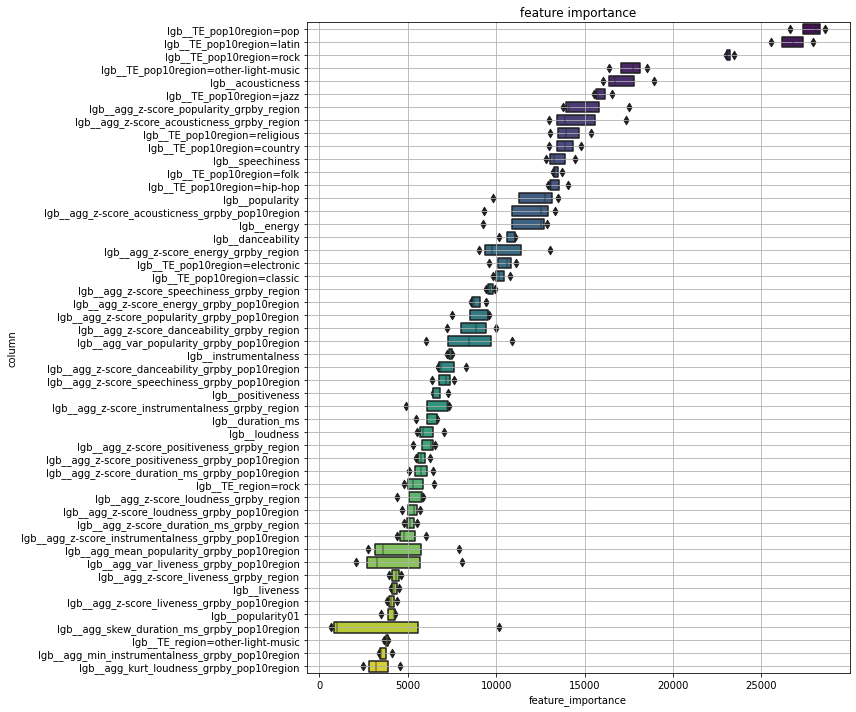

In [ ]:
fig, imp_df = tree_importance(X=train_x, 
                              y=train_y,
                              model=LGBM, 
                              cv=skf, 
                              cv_key=cv_key,
                              folds=3)

In [ ]:
# train
oof_01 = train_cv(X=train_x, 
                  y=train_y,
                  model=LGBM, 
                  cv=skf, 
                  cv_key=cv_key,
                  folds=folds, 
                  seeds=seeds,
                  metrics=macro_f1, 
                  name="LGBM")

oof_02 = train_cv(X=train_x, 
                  y=train_y,
                  model=KNN, 
                  cv=skf, 
                  cv_key=cv_key,
                  folds=folds, 
                  seeds=seeds,
                  metrics=macro_f1, 
                  name="KNN")

oof_03 = train_cv(X=train_x, 
                  y=train_y,
                  model=MLP, 
                  cv=skf, 
                  cv_key=cv_key,
                  folds=folds, 
                  seeds=seeds,
                  metrics=macro_f1, 
                  name="MLP")

[2021-05-08 11:37:10] - SEED:0, FOLD:0 >>>> val_score:0.6585
[2021-05-08 11:37:11] - SEED:0, FOLD:1 >>>> val_score:0.5754
[2021-05-08 11:37:12] - SEED:0, FOLD:2 >>>> val_score:0.6745
[2021-05-08 11:37:13] - SEED:0, FOLD:3 >>>> val_score:0.5355
[2021-05-08 11:37:14] - SEED:0, FOLD:4 >>>> val_score:0.6746
[2021-05-08 11:37:15] - SEED:0, FOLD:5 >>>> val_score:0.6646
[2021-05-08 11:37:15] - SEED:0, FOLD:6 >>>> val_score:0.6783
[2021-05-08 11:37:16] - SEED:0, FOLD:7 >>>> val_score:0.6070
[2021-05-08 11:37:17] - SEED:0, FOLD:8 >>>> val_score:0.6718
[2021-05-08 11:37:18] - SEED:0, FOLD:9 >>>> val_score:0.6207
[2021-05-08 11:37:18] - SEED:0, FOLD:10 >>>> val_score:0.6680
[2021-05-08 11:37:19] - SEED:0, FOLD:11 >>>> val_score:0.6189
[2021-05-08 11:37:20] - SEED:0, FOLD:12 >>>> val_score:0.6227
[2021-05-08 11:37:21] - SEED:0, FOLD:13 >>>> val_score:0.6428
[2021-05-08 11:37:21] - SEED:0, FOLD:14 >>>> val_score:0.6739
[2021-05-08 11:37:21] - seed:0 score:0.6469

[2021-05-08 11:37:22] - SEED:1, FOL

## stacking

In [ ]:
# simple stacking 
# なぜかシードが固定されていない??
class MLP2(MLP):
    def build_model(self, input_dim=None, output_dim=None):
        inp = L.Input(shape=(input_dim,))

        x = L.Dense(2 ** 6)(inp)
        x = L.BatchNormalization()(x)
        x = L.ReLU()(x)
        x = L.Dropout(0.1)(x)

        x = L.Dense(2 ** 6)(x)
        x = L.BatchNormalization()(x)
        x = L.ReLU()(x)
        x = L.Dropout(0.1)(x)

        x = L.Dense(2 ** 6)(x)
        x = L.BatchNormalization()(x)
        x = L.ReLU()(x)
        x = L.Dropout(0.1)(x)

        out = L.Dense(output_dim, activation="softmax")(x)
        model = tf.keras.Model(inputs=inp, outputs=out)
        model.compile(optimizer="adam", loss='categorical_crossentropy')
        self.mlp = model

In [ ]:
train_xs = np.hstack([oof_01, oof_02, oof_03])
train_xs = pd.DataFrame(train_xs).add_prefix("MLP__")

In [ ]:
oof_04 = train_cv(X=train_xs, 
                  y=train_y,
                  model=MLP2, 
                  cv=skf, 
                  cv_key=cv_key,
                  folds=folds, 
                  seeds=seeds,
                  metrics=macro_f1, 
                  name="MLP2")

[2021-05-08 11:41:17] - SEED:0, FOLD:0 >>>> val_score:0.6280
[2021-05-08 11:41:17] - SEED:0, FOLD:1 >>>> val_score:0.6755
[2021-05-08 11:41:18] - SEED:0, FOLD:2 >>>> val_score:0.6894
[2021-05-08 11:41:19] - SEED:0, FOLD:3 >>>> val_score:0.5329
[2021-05-08 11:41:19] - SEED:0, FOLD:4 >>>> val_score:0.6545
[2021-05-08 11:41:20] - SEED:0, FOLD:5 >>>> val_score:0.7443
[2021-05-08 11:41:20] - SEED:0, FOLD:6 >>>> val_score:0.6444
[2021-05-08 11:41:21] - SEED:0, FOLD:7 >>>> val_score:0.6974
[2021-05-08 11:41:21] - SEED:0, FOLD:8 >>>> val_score:0.7104
[2021-05-08 11:41:22] - SEED:0, FOLD:9 >>>> val_score:0.6830
[2021-05-08 11:41:22] - SEED:0, FOLD:10 >>>> val_score:0.6388
[2021-05-08 11:41:23] - SEED:0, FOLD:11 >>>> val_score:0.6656
[2021-05-08 11:41:23] - SEED:0, FOLD:12 >>>> val_score:0.6496
[2021-05-08 11:41:24] - SEED:0, FOLD:13 >>>> val_score:0.6394
[2021-05-08 11:41:24] - SEED:0, FOLD:14 >>>> val_score:0.7277
[2021-05-08 11:41:24] - seed:0 score:0.6740

[2021-05-08 11:41:25] - SEED:1, FOL

## weighted average

In [ ]:
# simple optimization
from scipy.optimize import minimize

def f(w, y_true, y_preds):
    y = np.average(y_preds, weights=w, axis=0)
    y = np.argmax(y, axis=1)
    score = f1_score(y_true, y, average="macro")
    return -score

def opt_weight(train_y=None, oof=None):
    file_name = os.path.join(TRAINED, "optimized_weights.pkl")
    if os.path.isfile(file_name):
        w = Util.load(file_name)
    else:
        w0 = np.array([0.05] * len(oof))
        res = minimize(f, w0, args=(train_y, oof), method='Powell')
        w = res["x"]
        print(res)
        Util.dump(w, file_name)
    return w


# get data
oof = [oof_04, oof_01, oof_02, oof_03]

# optim weight
opt_w = opt_weight(train_y, oof)
oof = np.average(oof, weights=opt_w, axis=0)

# get score
score = macro_f1(train_y, oof)  # macro f1
logger.info(f"★★★★★ Final Score is {score:.4f} ★★★★★")

[2021-05-08 11:42:39] - ★★★★★ Final Score is 0.6807 ★★★★★


## confusion matrix

In [ ]:
# 混合行列をplot する関数を定義
def visualize_confusion_matrix(y_true,
                               pred_label,
                               height=.6,
                               labels=None):
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 2, size * 1.5))
    sns.heatmap(conf, cmap='YlOrBr', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

    return fig

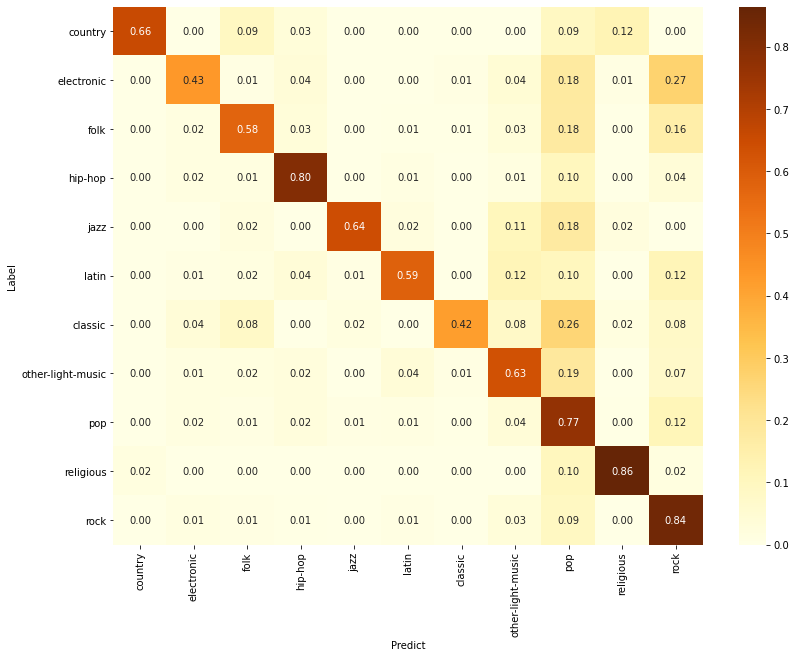

In [ ]:
oof_label = pd.Series(np.argmax(oof, axis=1))
# plot canfusion matrix
fig = visualize_confusion_matrix(y_true=train_y, pred_label=oof_label, labels=genre_labels["genre"])

# save fig
fig.savefig(f"{REPORTS}/confusion_matrix.png", dpi=150)